# Préparation des données

In [1]:
!pip install seaborn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import json
import yaml
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pwd

'c:\\Users\\carli\\OneDrive\\Documents\\0.ENSAE 3A\\S2\\NLP'

## Chargement des tables

In [3]:
data = json.load(open('entities.json'))

In [4]:
with open('tokens.yml', 'r', encoding='utf-8') as file:
    contenu = yaml.safe_load(file)

print(contenu)

{'age': {'start': 'Ⓐ', 'end': ''}, 'birth_date': {'start': 'Ⓑ', 'end': ''}, 'civil_status': {'start': 'Ⓒ', 'end': ''}, 'education_level': {'start': 'Ⓓ', 'end': ''}, 'employer': {'start': 'Ⓔ', 'end': ''}, 'firstname': {'start': 'Ⓕ', 'end': ''}, 'link': {'start': 'Ⓗ', 'end': ''}, 'lob': {'start': 'Ⓘ', 'end': ''}, 'maiden_name': {'start': 'Ⓙ', 'end': ''}, 'nationality': {'start': 'Ⓚ', 'end': ''}, 'observation': {'start': 'Ⓛ', 'end': ''}, 'occupation': {'start': 'Ⓜ', 'end': ''}, 'surname': {'start': 'Ⓞ', 'end': ''}, 'surname_household': {'start': 'Ⓟ', 'end': ''}}


## Préparation de la table

In [5]:
# df est notre base finale de travail, 
# Pour le moment on crée un dataframe vide avec les colonnes de notre fichier yaml

df = pd.DataFrame(columns=contenu.keys())

df


,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household


## Préparation des bases de travail

In [6]:
# L est une liste qui contient les différents symboles
# M est une liste qui contient les catégories qui correspondent aux symboles
L = []
M = []
for i in contenu.keys() : 
    M.append(i)
    L.append((contenu[i]['start']))


In [7]:
# A est une liste de liste qui contient les données de data (entities.json)
A = []
for i in data.keys() : 
    A.append(re.split('\n',data[i]))

In [8]:
# Lstr est une chaine de caractère qui contient les différents symboles
Lstr = '(' +  '|'.join(L[i] for i in range(len(L))) + ')'

In [9]:
Lstr

'(Ⓐ|Ⓑ|Ⓒ|Ⓓ|Ⓔ|Ⓕ|Ⓗ|Ⓘ|Ⓙ|Ⓚ|Ⓛ|Ⓜ|Ⓞ|Ⓟ)'

## Finition df

In [10]:
# On remplit maintenant le dataframe de travail df
m = 0
# Comme A est une liste de listes, je suis obligée de faire une double boucle
for a in range(len(A)):
    for b in range(len(A[a])):
        # Pour chaque individus de A[a][b], je crée une liste qui contient les symboles et la valeur associée.
        Aun = re.split(Lstr, A[a][b])
        if '' in Aun : 
            Aun.remove('')
        for i in range(0,len(Aun),2):
            # je regarde chaque symbole de Aun
            if Aun[i] in L : 
                n = L.index(Aun[i]) # je cherche l'index de Aun[i] dans L pour obtenir la catégorie correspondante
                df.loc[m, M[n]] = Aun[i+1] # à la colonne de la catégorie déterminée, j'affecte la valeur associée
        m = m + 1

df

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN,Desbois
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25440,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN,Chameton-Dideron
25441,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,idem,NaN,ouv chaus res,NaN,Ode
25442,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN,Berni
25443,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti,NaN


# Préparation de notre output 

On cherche à déterminer si notre individus est un chef de famille ou non, pour cela, on va créer la variable "chef" qui vaut 1 si l'individus est un chef et 0 sinon.

Pour cela, on va se servir de la variable 'link' qui contient la position de chaque individus dans la famille.

In [11]:
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

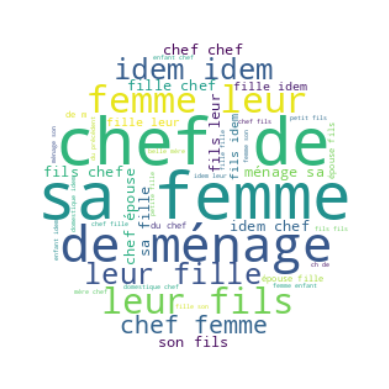

In [12]:
text = df['link']
text = text.str.cat(sep=' ')
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(str(text))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [11]:
trop = df['link'].unique().astype('str')
A = []
for i in range(len(trop)):
    if 'ch' in trop[i] : 
        A.append(trop[i])
    if 'Ch' in trop[i] :
        A.append(trop[i])
    if 'CH' in trop[i] :
        A.append(trop[i])

In [14]:
len(A)

177

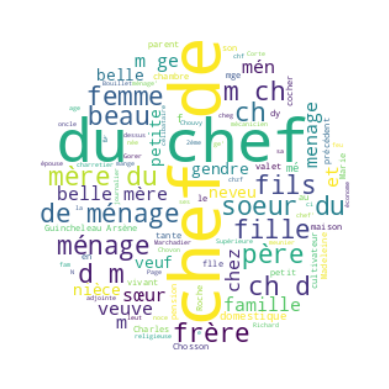

In [15]:
text = str(A)
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(str(text))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [12]:
mot_enlever = ['gendre', 'fille', 'fils', 'mere', 'pere', 'epouse', 'epoux', 'fem', 'mère', 'père', 'belle', 'valet', 'frère', 'cocher', 'soeur', 'domestique', 'pension', 'économe', 'ouvrier', 'neveu', 'nièce', 'épouse', 'Fille', 'parent', 'tante', 'oncle', 'religieuse', 'née', 'né', 'mére', 'Schouer', 'charron', 'maréchal', 'œ', 'charretier', 'f du ', 'poste']
B = A.copy()
for i in range(len(A)):
    for mot in mot_enlever:
        if mot in A[i] and A[i] in B:
            B.remove(A[i])

In [17]:
len(B)

67

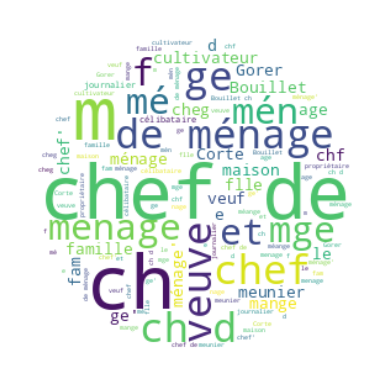

In [18]:
text = str(B)
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(str(text))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [13]:
df['chef'] = df['link'].isin(B)
df['chef'] = df['chef'].astype('int')

<AxesSubplot: xlabel='count', ylabel='chef'>

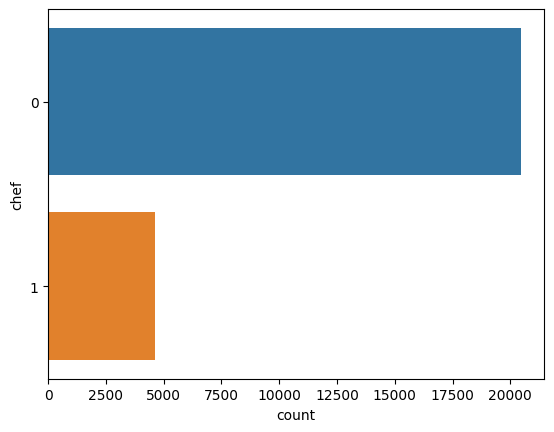

In [14]:
sns.countplot(data = df, y = 'chef')

# Hugging Face

In [15]:
df['phrase'] = df['firstname'].astype('str') + ' ; ' + df['surname'].astype('str') + '; a ' + df['age'].astype('str') + ' ans;' + ' ne en ' + df['birth_date'].astype('str') + '; cest ' + df['civil_status'].astype('str') + '; etude : ' + df['education_level'].astype('str') + '; son employeur :' + df['employer'].astype('str') + '; ville :' + df['lob'].astype('str') + '; nationalité : ' + df['nationality'].astype('str') + '; son travail : ' + df['occupation'].astype('str') + '; le nom du ménage est : ' + df['surname_household'].astype('str') + '; observation en plus : ' + df['observation'].astype('str') 

In [16]:
df['phrase'] = df['phrase'].astype('str')

In [23]:
X = list(df['phrase'])
y = list(df['chef'])
data = {'text': X, 'label': y}
#prepare the data
from datasets import Dataset
dataset = Dataset.from_dict(data)
dataset =dataset.train_test_split(test_size=0.2)
train_set = dataset['train']
test_set = dataset['test']
#tokenize
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_train_data = train_set.map(preprocess_function, batched=True)
tokenized_test_data = test_set.map(preprocess_function, batched=True)
## deal with different lenghts 
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#evaluate
import evaluate

accuracy = evaluate.load("accuracy")
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#call model
id2label = {0: "pas chef", 1: "chef"}
label2id = {"pas chef": 0, "chef": 1}
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
#train
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()




Map:   0%|          | 0/20059 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5015 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/tordjx/miniconda3/envs/mujoco_py/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler'

/home/tordjx/miniconda3/envs/mujoco_py/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.224300,0.174665,0.934995
2,0.166400,0.164095,0.938983


Checkpoint destination directory my_awesome_model/checkpoint-627 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/tordjx/miniconda3/envs/mujoco_py/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory my_awesome_model/checkpoint-1254 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1254, training_loss=0.1871706066709576, metrics={'train_runtime': 337.7411, 'train_samples_per_second': 118.783, 'train_steps_per_second': 3.713, 'total_flos': 762638616798288.0, 'train_loss': 0.1871706066709576, 'epoch': 2.0})

In [24]:
#manual tests : lucie est elle chef de famille ??????!!!!!!
text = "lucie, carlier, 21 ans"
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model, tokenizer = tokenizer)
classifier(text)

[{'label': 'pas chef', 'score': 0.7365753650665283}]

/home/tordjx/miniconda3/envs/mujoco_py/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


test accuracy :  0.9389830508474576


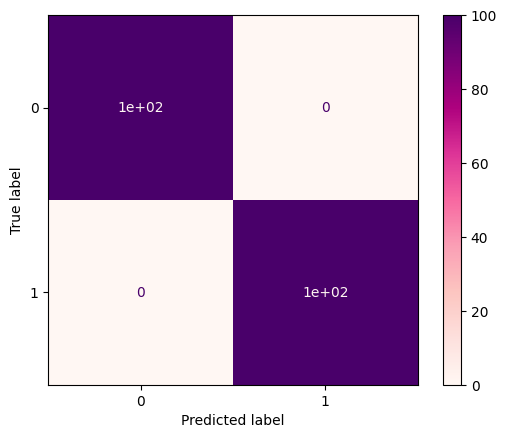

In [26]:
trainer.model = trainer.model.cuda()
out = trainer.predict(tokenized_test_data)
print("test accuracy : ", out.metrics['test_accuracy'] )
preds = out.label_ids
ground_truth = test_set['label']
cm = confusion_matrix(ground_truth, preds)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

disp = disp.plot(cmap=plt.cm.RdPu)

plt.show()

# Méthode 2 

In [26]:
df

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household,chef,phrase
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN,0,Cyrille ; Breton ; a 25 ans; ne en nan; cest...
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi,0,Auguste ; nan; a 30 ans; ne en nan; cest Gar...
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol,0,Pierre ; nan; a 24 ans; ne en nan; cest Garç...
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN,Desbois,0,Alexandre ; nan; a 48 ans; ne en nan; cest H...
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat,NaN,0,Zélie ; Vignat ; a 30 ans; ne en nan; cest n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25440,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN,Chameton-Dideron,1,Marie ; nan; a nan ans; ne en 1869 ; cest nan...
25441,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,idem,NaN,ouv chaus res,NaN,Ode,1,Marie ; nan; a nan ans; ne en 1863 ; cest nan...
25442,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN,Berni,1,Nello ; nan; a nan ans; ne en 1886 ; cest nan...
25443,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti,NaN,0,Annunziata ; Berni-Laureti ; a nan ans; ne en...


In [27]:
train, test = train_test_split(df[['phrase','chef']],test_size=0.2, random_state=42)

In [28]:
train_x, train_y = train.phrase, train.chef
test_x, test_y = test.phrase, test.chef

In [29]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
X_train_counts = vectorizer.transform(train_x)
X_test_counts = vectorizer.transform(test_x)

## MultinomialNB 

In [30]:
MB = MultinomialNB()

MB.fit(X_train_counts, train_y)
MB.score(X_test_counts, test_y)

0.8552342971086739

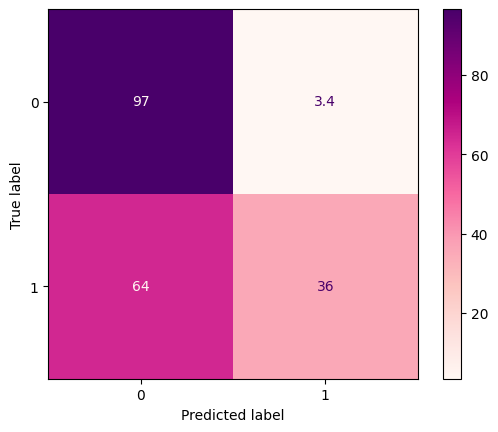

In [31]:
cm = confusion_matrix(test_y, MB.predict(X_test_counts))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=MB.classes_)

disp = disp.plot(cmap=plt.cm.RdPu)

plt.show()

## Random forest

In [17]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()

In [18]:
# what are the coltypes?
df.dtypes

from sklearn import preprocessing
lbl = preprocessing.OneHotEncoder().fit(df)

df_encoded = df.copy()
list_str_obj_cols = df_encoded.columns[df_encoded.dtypes == "object"].tolist()
le_dict={}
for col in list_str_obj_cols:
    le_dict[col] = label_encoder.fit(df_encoded[col])
    df_encoded[col] = le_dict[col].transform(df_encoded[col])

onehot_encoder.fit(df_encoded)
refreshed_df = onehot_encoder.transform(df_encoded).toarray()
    
# print coltypes
df_encoded.dtypes

age                  int32
birth_date           int32
civil_status         int32
education_level      int32
employer             int32
firstname            int32
link                 int32
lob                  int32
maiden_name          int32
nationality          int32
observation          int32
occupation           int32
surname              int32
surname_household    int32
chef                 int32
phrase               int32
dtype: object

In [32]:
train, test = train_test_split(df_encoded.drop(['phrase','maiden_name','education_level','link'],axis = 1),test_size=0.2, random_state=42)

In [33]:
train_x, train_y = train.drop('chef',axis = 1), train.chef
test_x, test_y = test.drop('chef',axis = 1), test.chef

In [34]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
X_train_counts = vectorizer.transform(train_x)
X_test_counts = vectorizer.transform(test_x)

0.846061814556331


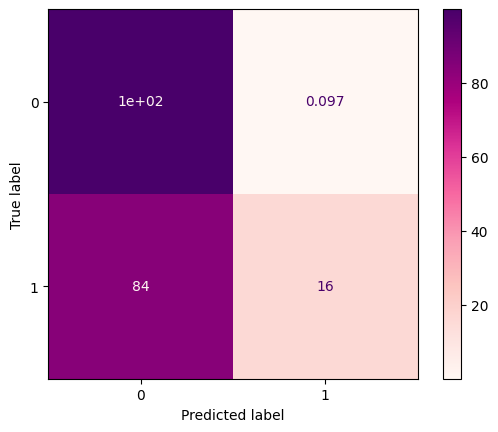

In [35]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100)#, learning_rate=0.01, random_state=500)
#model.fit(train_x, train_y)
model.fit(train_x, train_y)

print(accuracy_score(test_y, model.predict(test_x).astype('int')))

cm = confusion_matrix(test_y, model.predict(test_x).astype('int'))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

disp = disp.plot(cmap=plt.cm.RdPu)

plt.show()

In [25]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, scale_pos_weight= 750)#, learning_rate=0.01, random_state=500)
#model.fit(train_x, train_y)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
model.predict(test_x).astype('int')

array([0, 0, 1, ..., 0, 0, 0])

In [26]:
accuracy_score(test_y, model.predict(test_x).astype('int'))

0.8819541375872383

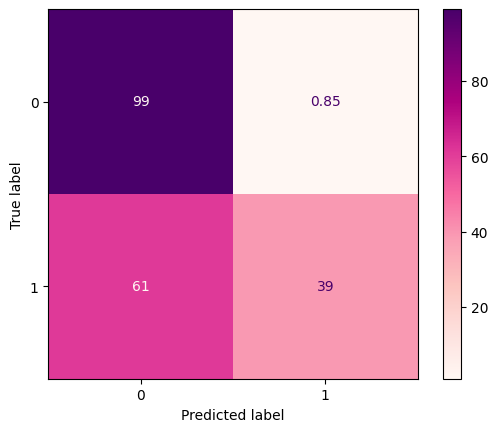

In [27]:
cm = confusion_matrix(test_y, model.predict(test_x).astype('int'))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

disp = disp.plot(cmap=plt.cm.RdPu)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


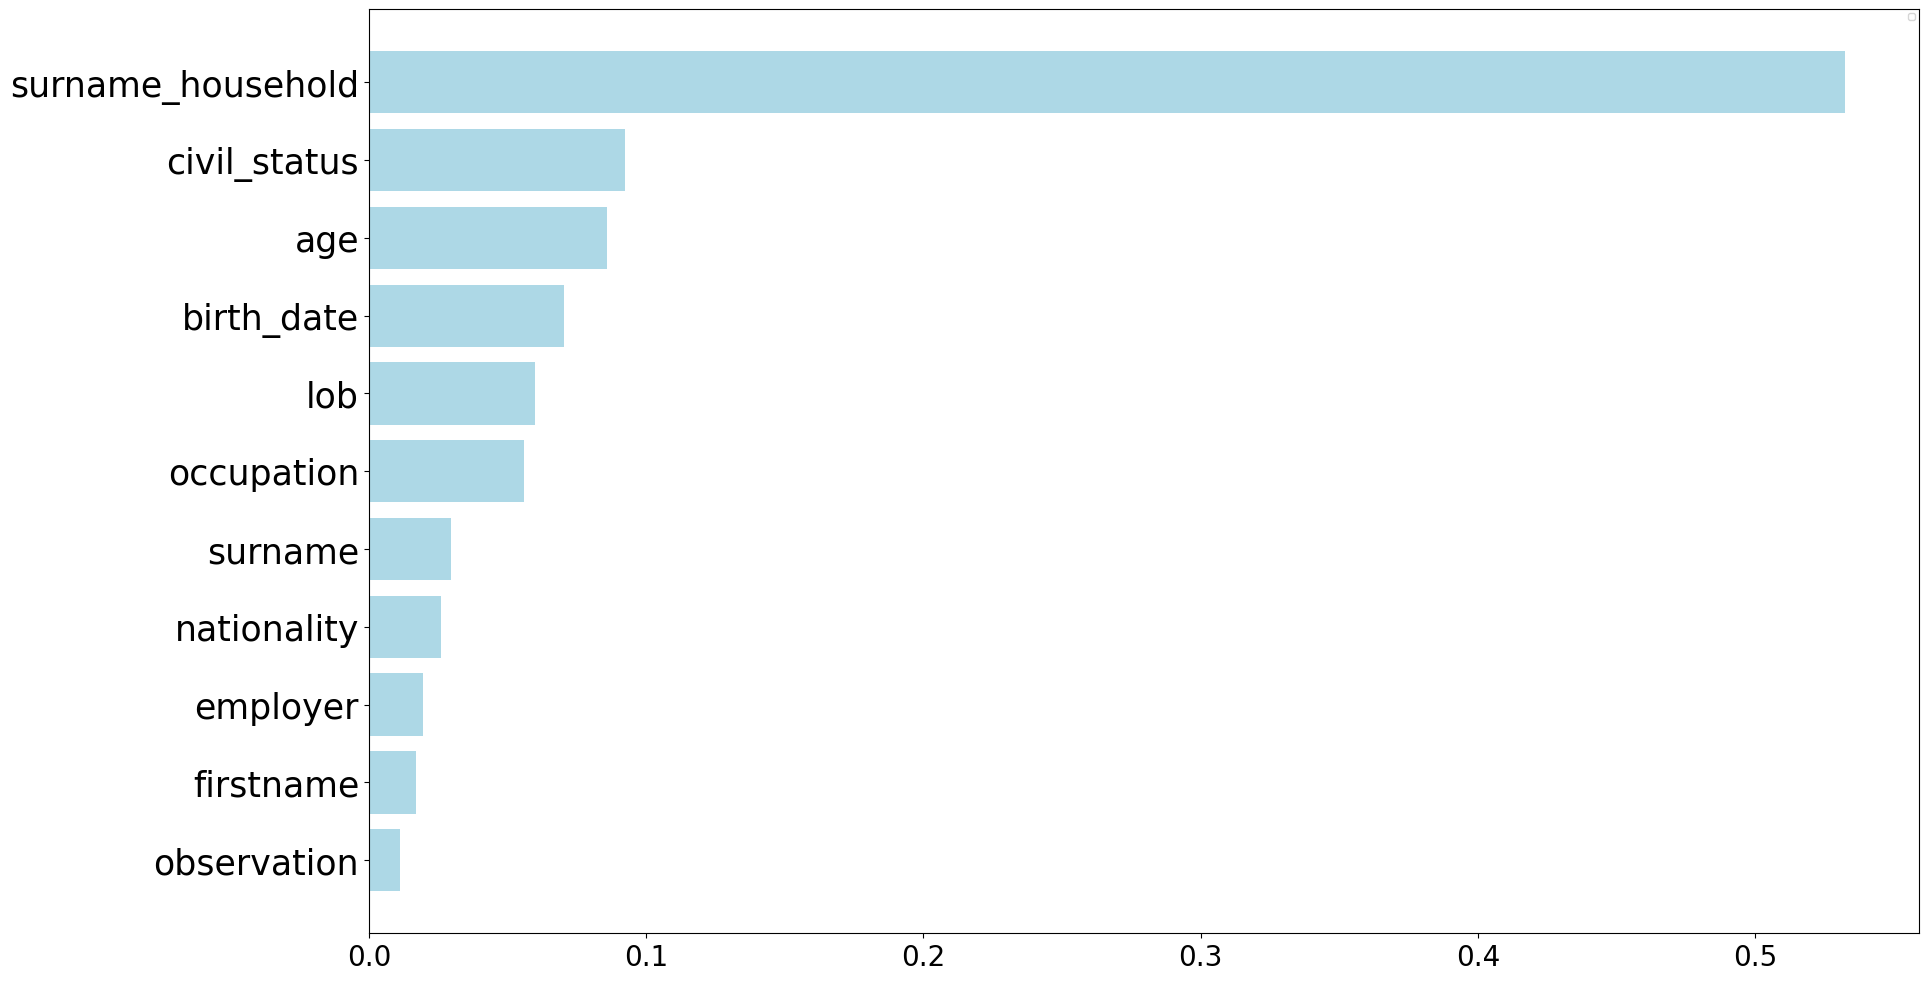

In [28]:
plt.figure(figsize=(20, 12))


sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(test_x.columns[sorted_feature_importance], 
         model.feature_importances_[sorted_feature_importance], 
         color='lightblue')

# showing the plotting
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(prop={'size': 6})
plt.show()

In [36]:
import shap as shap

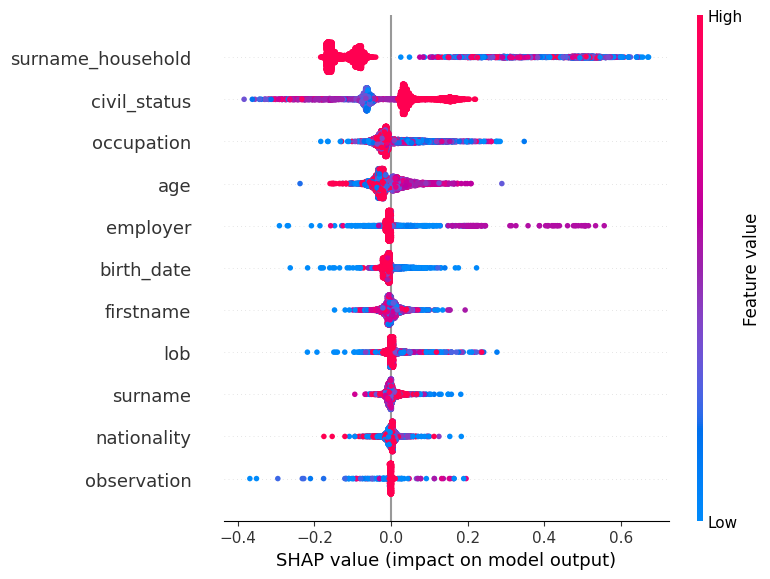

In [47]:
plt.figure(figsize=(20, 12))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

shap.summary_plot(shap_values, test_x, max_display = test_x.shape[1])

0.8699900299102692


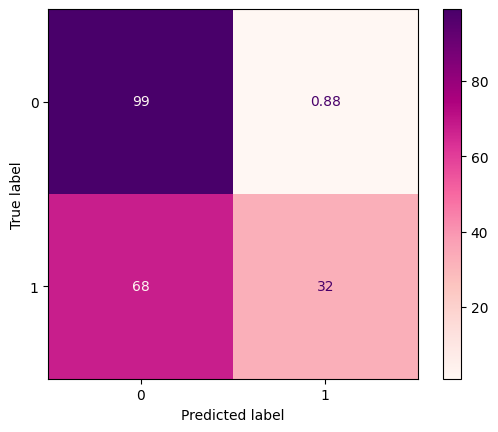

In [38]:
train, test = train_test_split(df_encoded.drop(['phrase','surname_household','maiden_name','education_level','link'],axis = 1),test_size=0.2, random_state=42)

train_x, train_y = train.drop('chef',axis = 1), train.chef
test_x, test_y = test.drop('chef',axis = 1), test.chef

vectorizer = CountVectorizer()
vectorizer.fit(train_x)
X_train_counts = vectorizer.transform(train_x)
X_test_counts = vectorizer.transform(test_x)

from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, scale_pos_weight= 750)#, learning_rate=0.01, random_state=500)
#model.fit(train_x, train_y)
model.fit(train_x, train_y)

print(accuracy_score(test_y, model.predict(test_x).astype('int')))

cm = confusion_matrix(test_y, model.predict(test_x).astype('int'))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

disp = disp.plot(cmap=plt.cm.RdPu)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


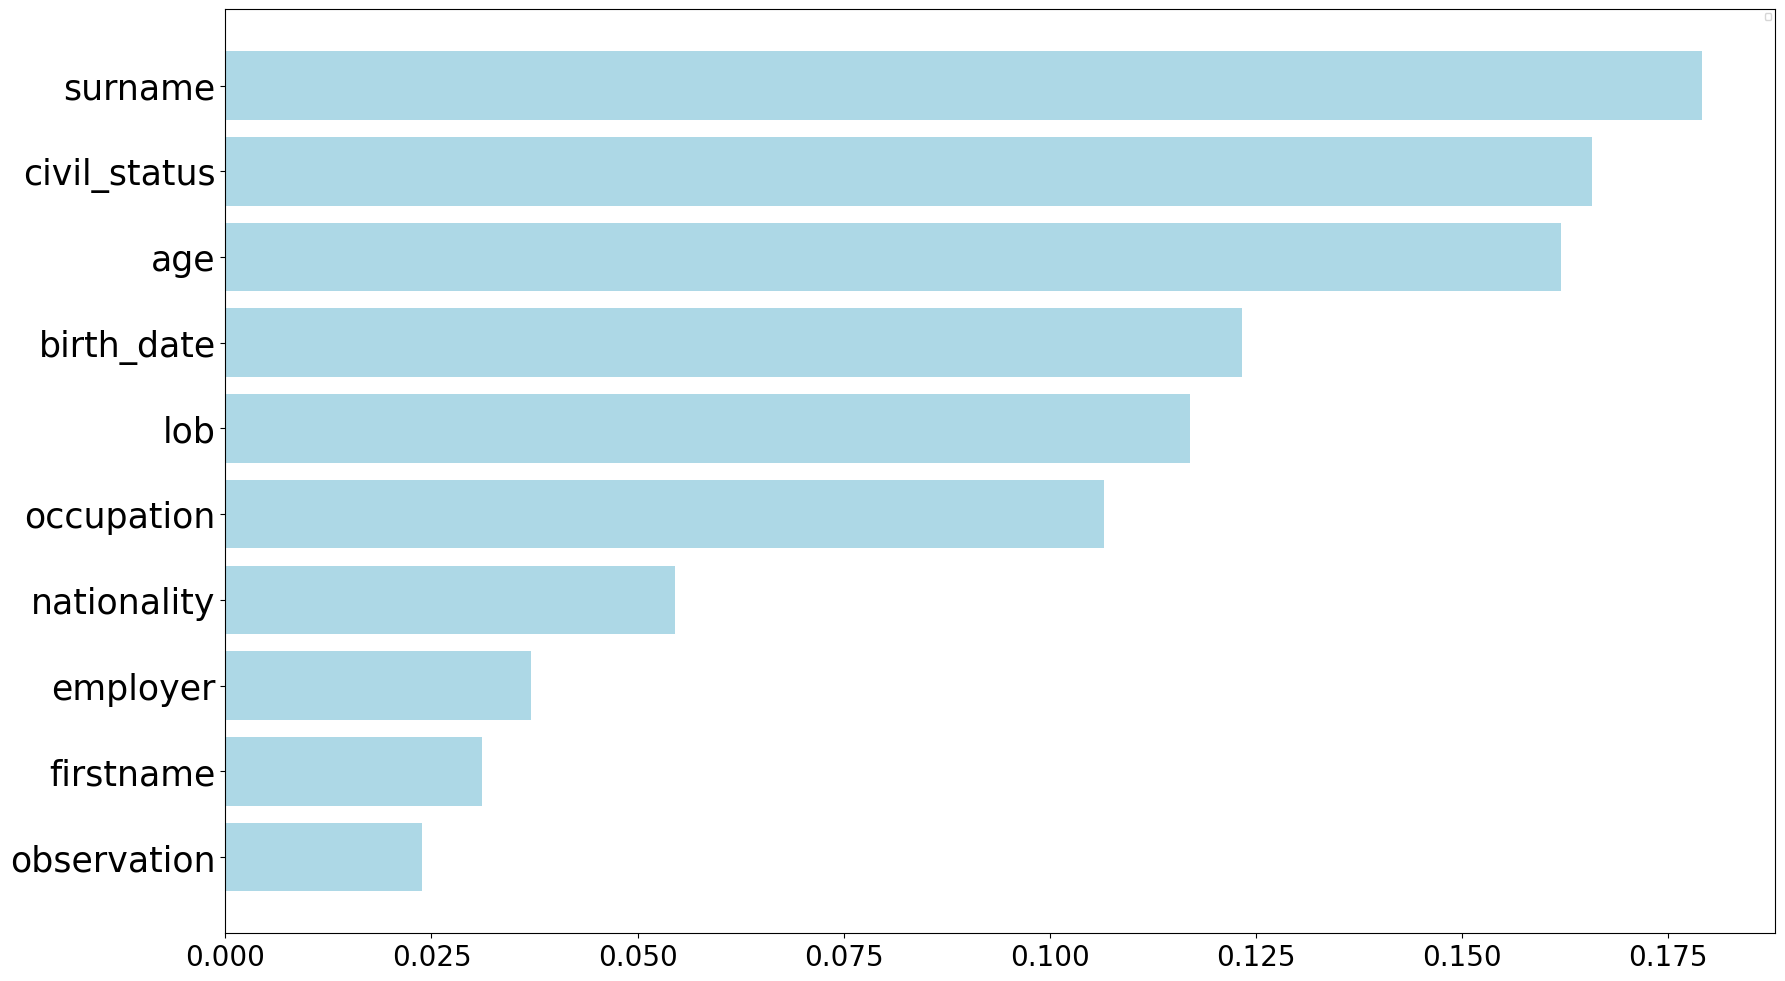

In [39]:
plt.figure(figsize=(20, 12))


sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(test_x.columns[sorted_feature_importance], 
         model.feature_importances_[sorted_feature_importance], 
         color='lightblue')

# showing the plotting
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(prop={'size': 6})
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


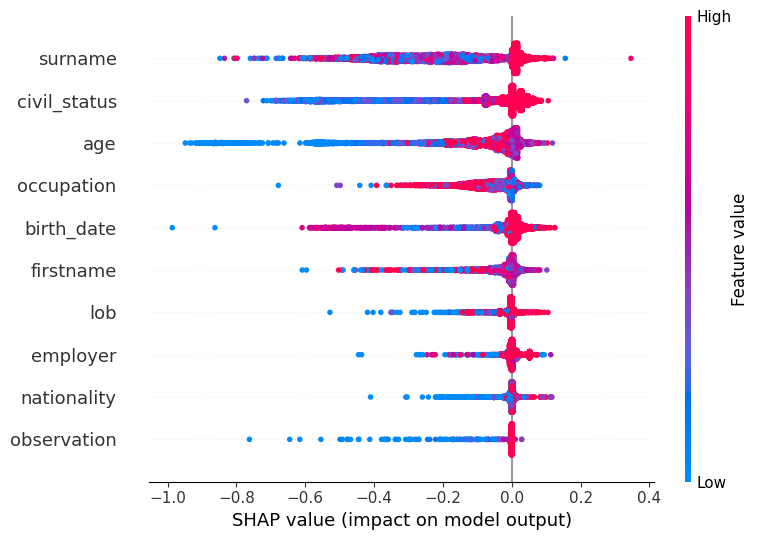

In [40]:
plt.figure(figsize=(20, 12))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

shap.summary_plot(shap_values, test_x, max_display = test_x.shape[1])

In [48]:
df.columns

Index(['age', 'birth_date', 'civil_status', 'education_level', 'employer',
       'firstname', 'link', 'lob', 'maiden_name', 'nationality', 'observation',
       'occupation', 'surname', 'surname_household', 'chef', 'phrase'],
      dtype='object')

Expliquer pourquoi certains modèles fonctionnent = comprendre les modèles (sans NLP ?)

ajouter des trucs pas de NLP :

    enlever des colonnes pour voir s'il est plus performant 

    etudier la profession/ colonne qui a du text et y appliquer une tache de traitement => couper une partie du mot / prédire la suite du mot et utiliser la nv variable créée pour prédire le chef 

faire preuve de créativité 
